<a href="https://colab.research.google.com/github/kjspring/stress-detection-wearable-devices/blob/main/modeling_WESAD_all_subjects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load pickled data

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import pickle
import pandas as pd
import numpy as np

# Main file directory for this notebook on Google Drive
os.chdir('/content/drive/MyDrive/stress-prediction')
# absolute path of data directory
PATH = os.path.join(os.path.abspath(os.getcwd()), 'data') # Path of data folder on Google Drive

import joblib
data = joblib.load(f"{PATH}/pickle/WESAD_model_data.pickle") # read pickle file
#labels = joblib.load(f"{PATH}/pickle/WESAD_labels_model.pickle") # read pickle file

Mounted at /content/drive


In [2]:
def plot_evaluation(model, file_name):
    '''
    Plotting helper function.
    Plots the Training and validation accuracy
    as well as the training and validation loss
    over the number of epochs specified
    '''
    # Import libraries
    import matplotlib.pyplot as plt
    
    acc = model.history['binary_accuracy']
    val_acc = model.history['val_binary_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(1, len(loss) + 1)
    
    fig, ax = plt.subplots(1, 2, figsize=(24 , 8))
    ax[0].plot(epochs_range, acc, 'g-', label='Training Accuracy')
    ax[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].title.set_text('Training and Validation Accuracy')

    ax[1].plot(epochs_range, loss, 'g-', label='Training Loss')
    ax[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    ax[1].legend(loc='upper right')
    ax[1].title.set_text('Training and Validation Loss')
    fig.patch.set_facecolor('white')
    plt.savefig(f'{file_name}')
    plt.show()

In [8]:
def evaluate_model(model_filepath, history_filepath, val_data, test_data, save_plot_path):
  '''
  What does this function do?
  val_data: validation data generator
  test_data: testing data generator
  '''
  # Evaluate the model
  from tensorflow.keras.models import load_model
  import joblib

  # Load the model
  model = load_model(model_filepath)
  model_eval_val = model.evaluate(val_data,
                                  use_multiprocessing=True,
                                  batch_size=batch_size)
  
  # Load the training fit history
  fit_history = joblib.load(history_filepath) # read pickle file

  # Make Plot of Training Fit
  plot_evaluation(fit_history, save_plot_path)

  # Print validation and testing metrics
  print(f'Validation Binary Accuracy is: {model_eval_val[1]:.2f}')
  model_eval_test = model.evaluate(test_data,
                                  use_multiprocessing=True,
                                  batch_size=batch_size)
  print(f'Testing Binary Accuracy is: {model_eval_test[1]:.2f}')
  return model, fit_history

In [9]:
data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RSP_Rate    float64
 1   EDA_Phasic  float64
 2   ECG_Rate    float64
 3   Temp        float32
 4   label       int32  
dtypes: float32(1), float64(3), int32(1)
memory usage: 117.4 MB


In [10]:
data[0].describe()

,RSP_Rate,EDA_Phasic,ECG_Rate,Temp,label
count,3.847200e+06,3.847200e+06,3.847200e+06,3.847200e+06,3.847200e+06
mean,1.479597e+01,8.773488e-07,9.201702e+01,3.477422e+01,1.319141e-01
std,5.429806e+00,5.118602e-03,1.541436e+01,4.796361e-01,3.383974e-01
min,2.319673e+00,-5.590441e-02,5.391528e+01,3.365948e+01,0.000000e+00
25%,1.046479e+01,-1.277041e-03,7.972357e+01,3.438724e+01,0.000000e+00
50%,1.530387e+01,-6.004727e-05,9.191419e+01,3.461252e+01,0.000000e+00
75%,1.836961e+01,1.148620e-03,1.021086e+02,3.526480e+01,0.000000e+00
max,5.166052e+01,9.205739e-02,1.527273e+02,3.577805e+01,1.000000e+00


In [11]:
'''
engineer features that capture the patterns in your data that are relevant to 
predicting stress, you can compute statistics over different time intervals.
function compute_features that computes the mean and standard deviation of EDA 
over different time intervals using the rolling function. We then apply this 
function to each dataframe in the list using a list comprehension.
'''
# Define a function to compute features
def compute_features(df):
   # Windows in samples: 1-minute, 5-minute, 10-minute
    #windows = [int(60 * 700), int(300 * 700), int(600 * 700)]  

    #for window in windows:
    #    for col in ['RSP_Phase', 'EDA_Phasic', 'ECG_Rate', 'Temp']:
    #        df[f'{col}_mean_{window // 700}s'] = df[col].rolling(window=window).mean()
    #        df[f'{col}_std_{window // 700}s'] = df[col].rolling(window=window).std()

    # Drop rows with missing values
    #df.dropna(inplace=True)

    return df

# Apply the function to each dataframe in the list
data_frames_list = [compute_features(df) for df in data]


In [12]:
data_frames_list[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RSP_Rate    float64
 1   EDA_Phasic  float64
 2   ECG_Rate    float64
 3   Temp        float32
 4   label       int32  
dtypes: float32(1), float64(3), int32(1)
memory usage: 117.4 MB


In [13]:
data_frames_list[0].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
RSP_Rate,3847200.0,1.479597e+01,5.429806,2.319673,10.464794,15.303869,18.369611,51.660517
EDA_Phasic,3847200.0,8.773488e-07,0.005119,-0.055904,-0.001277,-0.000060,0.001149,0.092057
ECG_Rate,3847200.0,9.201702e+01,15.414356,53.915276,79.723566,91.914189,102.108630,152.727273
Temp,3847200.0,3.477422e+01,0.479636,33.659485,34.387238,34.612518,35.264801,35.778046
label,3847200.0,1.319141e-01,0.338397,0.000000,0.000000,0.000000,0.000000,1.000000


In [14]:
data_frames_list[0].head()

,RSP_Rate,EDA_Phasic,ECG_Rate,Temp,label
0,14.481092,-0.002589,91.999226,33.695862,0
1,14.481092,-0.002616,91.999226,33.741333,0
2,14.481092,-0.002641,91.999226,33.717072,0
3,14.481092,-0.002665,91.999226,33.741333,0
4,14.481092,-0.002688,91.999226,33.747406,0


In [15]:
## Include Subject
for i, df in enumerate(data):
    # Set subject as categorical
    df['subject'] = i
    df['subject'] = df['subject'].astype('category')

                   

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Concatenate the dataframes together
df = pd.concat(data_frames_list)

# Downsample the dataframe
target_hz = 1
resample_factor = int(700 / target_hz)
df = df.iloc[::resample_factor, :]

# Drop any columns that have any missing values
df = df.dropna(axis=1, how='any')

# Select 80% of subjects for training
train_subjects = df['subject'].unique()[:int(0.8 * len(df['subject'].unique()))]

# Split the data into training, testing, and validation sets by subject
train_dfs = []
test_dfs = []
val_dfs = []

for i, group in df.groupby('subject'):
    if i in train_subjects:
        train, test = train_test_split(group, test_size=0.2, random_state=42)
        train, val = train_test_split(train, test_size=0.2, random_state=42)
        
        train_dfs.append(train)
        test_dfs.append(test)
        val_dfs.append(val)
    else:
        test_dfs.append(group)

train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)
val_df = pd.concat(val_dfs)

# Standardize the data
scaler = StandardScaler()
cols_to_transform = [col for col in train_df.columns if col not in ['subject', 'label']]
train_df[cols_to_transform] = scaler.fit_transform(train_df[cols_to_transform])
test_df[cols_to_transform] = scaler.transform(test_df[cols_to_transform])
val_df[cols_to_transform] = scaler.transform(val_df[cols_to_transform])

# Reset the index of the dataframes
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Apply PCA to the training set only
n_components = 25
pca = PCA(n_components=n_components)
pca.fit(train_df[cols_to_transform])

# Transform the validation and testing sets using the PCA from the training set
train_df_pca = pca.transform(train_df[cols_to_transform])
test_df_pca = pca.transform(test_df[cols_to_transform])
val_df_pca = pca.transform(val_df[cols_to_transform])

# Concatenate the transformed data with the original dataframes
pca_col_names = ['PC' + str(i) for i in range(1, n_components+1)]
train_df = pd.concat([train_df[['subject', 'label']], pd.DataFrame(train_df_pca, columns=pca_col_names)], axis=1)
test_df = pd.concat([test_df[['subject', 'label']], pd.DataFrame(test_df_pca, columns=pca_col_names)], axis=1)
val_df = pd.concat([val_df[['subject', 'label']], pd.DataFrame(val_df_pca, columns=pca_col_names)], axis=1)

# Set subject as categorical
train_df['subject'] = train_df['subject'].astype('category')
test_df['subject'] = test_df['subject'].astype('category')
val_df['subject'] = val_df['subject'].astype('category')


ValueError: ignored

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.show()

<Axes: >

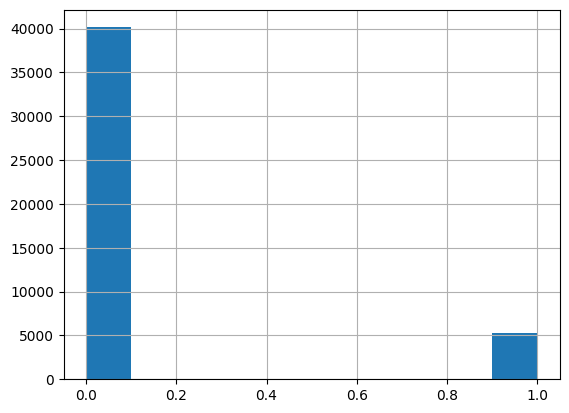

In [17]:
train_df['label'].hist()

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define batch size and sequence length
duration = 10 # minutes
batch_size = 64
seq_length = target_hz * 60 * duration # full length of sequence

# Calculate the offset in rows
offset_minutes = 5
offset_rows = offset_minutes * target_hz * 60 # seconds

# Extract values from DataFrame
train_data = train_df.values
val_data = val_df.values
test_data = test_df.values

# Create data generators with start_index
train_gen = TimeseriesGenerator(train_data, 
                                train_df['label'].values,
                                length=seq_length, 
                                batch_size=batch_size, 
                                shuffle=False,
                                start_index=offset_rows)

val_gen = TimeseriesGenerator(val_data, 
                              val_df['label'].values,
                              length=seq_length, 
                              batch_size=batch_size, 
                              start_index=offset_rows)

test_gen = TimeseriesGenerator(test_data, 
                               test_df['label'].values,
                               length=seq_length, 
                               batch_size=batch_size, 
                               start_index=offset_rows)


In [19]:
# get the first batch of data
x_batch, y_batch = test_gen[0]

# check the shape of the input batch
print(x_batch.shape)

(64, 600, 6)


In [20]:
# Assuming you have defined a TimeseriesGenerator called 'train_gen'

# Get the targets for the first batch of the generator
batch_x, batch_y = train_gen[0]

# 'batch_y' contains the targets for the batch, which can be accessed as follows:
for e in batch_y:
  print(e)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
1
0
0
0
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0


In [21]:
# Callbacks Function
def callbacks(checkpoint_file, patience=3):

  # import necessary libraries
  from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

  # Callback and Early Stopping
  callbacks = [EarlyStopping(monitor='val_loss', 
                             verbose=1, 
                             patience=patience,
                             restore_best_weights=True,
                             mode='min'
                             ),
              ModelCheckpoint(checkpoint_file, 
                              save_best_only=True,
                              verbose=0
                              ),
              TensorBoard(log_dir='./logs', histogram_freq=1, 
                          embeddings_freq=1, 
                          update_freq='epoch')
  ]
  return callbacks

Class 0 (Non-stress): 88.49%
Class 1 (Stress): 11.51%


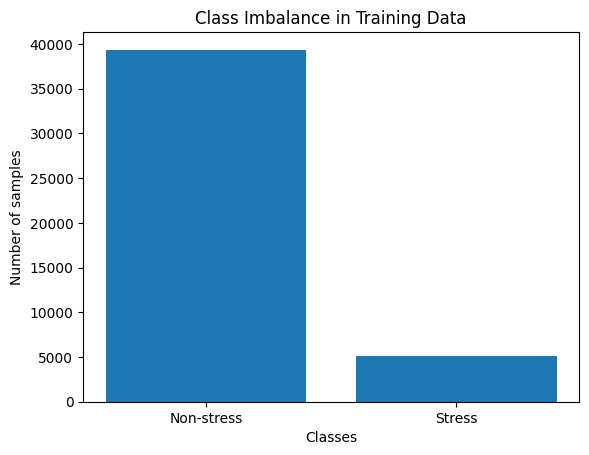

In [22]:
# Class imbalance

# Class weight correction
from sklearn.utils import class_weight

y_train = np.concatenate([train_gen[i][1] for i in range(len(train_gen))])

import matplotlib.pyplot as plt
import numpy as np

# Calculate class counts
unique_classes, class_counts = np.unique(y_train, return_counts=True)
class_percentages = (class_counts / class_counts.sum()) * 100

# Calculate class weights
class_weights = class_weight.compute_sample_weight(class_weight='balanced', 
                                                   y=y_train)
class_weights_dict = {class_label: class_weight
                      for class_label, class_weight in zip(unique_classes,  len(y_train) / (2*class_counts))}

# Print class percentages
for class_id, percentage in zip(unique_classes, class_percentages):
    print(f"Class {class_id} ({'Non-stress' if class_id == 0 else 'Stress'}): {percentage:.2f}%")

# Create a bar plot for class counts
plt.bar(unique_classes, class_counts, tick_label=['Non-stress', 'Stress'])
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.title('Class Imbalance in Training Data')
plt.show()

In [23]:
def confusion_matrix_plot(model, data, save_file=None):
    # Confusion Matrix
    y_pred_probs = model.predict(data)
    y_pred = (y_pred_probs > 0.5).astype(int)

    y_true = []
    for _, batch_labels in data:
        y_true.extend(batch_labels)
    y_true = np.array(y_true)

    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)

    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    if save_file:
        plt.savefig(f'{save_file}')
    plt.show()


In [24]:
# Classification Report
from sklearn.metrics import classification_report

def classification_report_output(model, data, save_file=None):
    y_pred_probs = model.predict(data)
    y_pred = (y_pred_probs > 0.5).astype(int)

    y_true = []
    for _, batch_labels in data:
        y_true.extend(batch_labels)
    y_true = np.array(y_true)

    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    if save_file:
        report_df.to_csv(save_file, index=True)

    print(report_df)

In [25]:
'''
Model_0: Densely Connected Network
This neural network starts by flattening the data dn then runs it through two 
Dense layers.

This is a simple and cheap model to test the data generator and the metrics
being used to evaluate.
'''

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, Flatten

# Build Model 0
inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))
x = Flatten()(inputs)
x = Dense(64, activation='relu')(x)
outputs = Dense(1)(x)
model_0 = keras.Model(inputs, outputs, name='model_0')

# Compile Model 0
model_0.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['binary_accuracy'])


model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 6)]          0         
                                                                 
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 64)                230464    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 230,529
Trainable params: 230,529
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Parameters for fitting and saving model training data
epochs = 200
model_0_filepath = 'models/model_dense.keras'
history_0_filepath = 'models/trainHistoryDict/model_0_dense_history.pkl'

In [27]:
# Fit the model to the training data
history_0 = model_0.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=True, 
                        epochs=epochs,
                        class_weight=class_weights_dict,
                        callbacks=callbacks(model_0_filepath,
                                            patience=10),
                        # remove the last batch if not even
                        #steps_per_epoch=len(train_gen)-1
                        )

# Pickle the Traning Fit History
with open(history_0_filepath, 'wb') as file_pi:
    pickle.dump(history_0, file_pi)

Epoch 1/200
696/696 [==============================] - 16s 14ms/step - loss: 7.7125 - binary_accuracy: 0.8849 - val_loss: 1.6921 - val_binary_accuracy: 0.8903
Epoch 2/200
696/696 [==============================] - 4s 5ms/step - loss: 7.7125 - binary_accuracy: 0.8849 - val_loss: 1.6921 - val_binary_accuracy: 0.8903
Epoch 3/200
696/696 [==============================] - 5s 7ms/step - loss: 7.7125 - binary_accuracy: 0.8849 - val_loss: 1.6921 - val_binary_accuracy: 0.8903
Epoch 4/200
696/696 [==============================] - 4s 5ms/step - loss: 7.7125 - binary_accuracy: 0.8849 - val_loss: 1.6921 - val_binary_accuracy: 0.8903
Epoch 5/200
696/696 [==============================] - 3s 5ms/step - loss: 7.7125 - binary_accuracy: 0.8849 - val_loss: 1.6921 - val_binary_accuracy: 0.8903
Epoch 6/200
696/696 [==============================] - 3s 5ms/step - loss: 7.7125 - binary_accuracy: 0.8849 - val_loss: 1.6921 - val_binary_accuracy: 0.8903
Epoch 7/200
696/696 [==============================] - 3

164/164 [==============================] - 1s 7ms/step - loss: 1.6921 - binary_accuracy: 0.8903


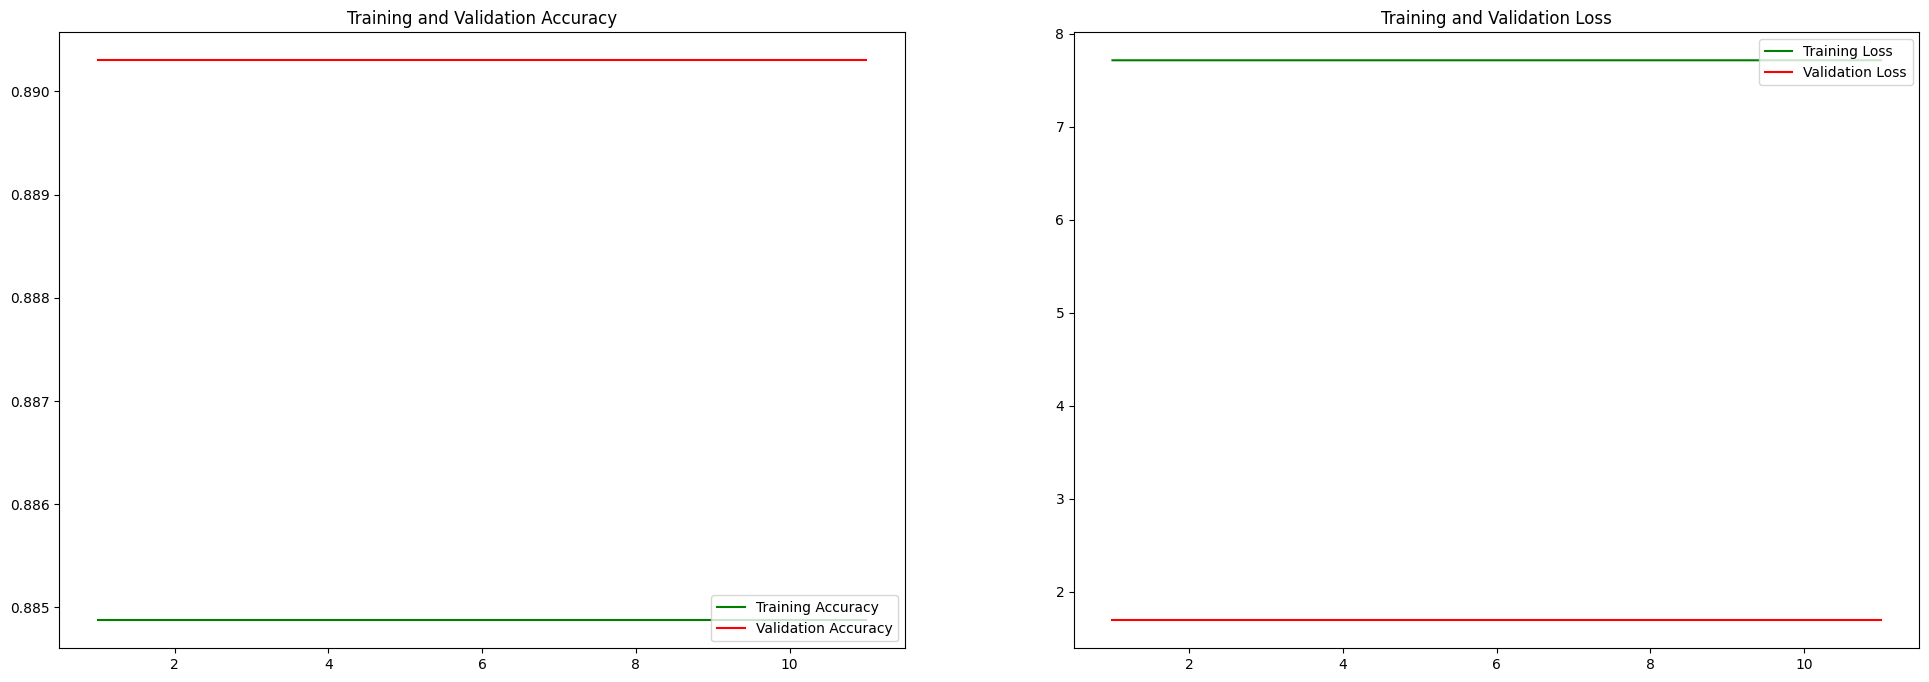

Validation Binary Accuracy is: 0.89
457/457 [==============================] - 3s 6ms/step - loss: 1.7626 - binary_accuracy: 0.8857
Testing Binary Accuracy is: 0.89


In [28]:
# Load and Evaluate Model
model_0, history_0 = evaluate_model(model_0_filepath, 
                         history_0_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_0_evaluation.pdf')

696/696 [==============================] - 1s 2ms/step


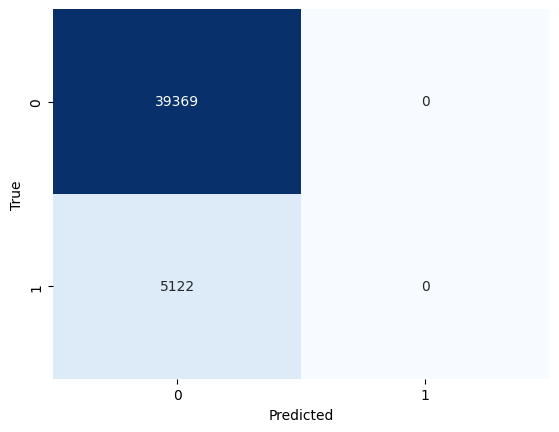

696/696 [==============================] - 1s 2ms/step
              precision    recall  f1-score       support
0              0.884876  1.000000  0.938922  39369.000000
1              0.000000  0.000000  0.000000   5122.000000
accuracy       0.884876  0.884876  0.884876      0.884876
macro avg      0.442438  0.500000  0.469461  44491.000000
weighted avg   0.783005  0.884876  0.830829  44491.000000
 51/164 [========>.....................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


164/164 [==============================] - 0s 2ms/step


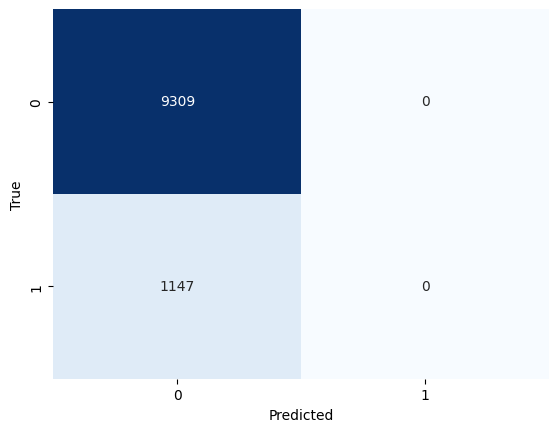

164/164 [==============================] - 0s 2ms/step
              precision    recall  f1-score       support
0              0.890302  1.000000  0.941968   9309.000000
1              0.000000  0.000000  0.000000   1147.000000
accuracy       0.890302  0.890302  0.890302      0.890302
macro avg      0.445151  0.500000  0.470984  10456.000000
weighted avg   0.792638  0.890302  0.838636  10456.000000
 54/457 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


457/457 [==============================] - 1s 2ms/step


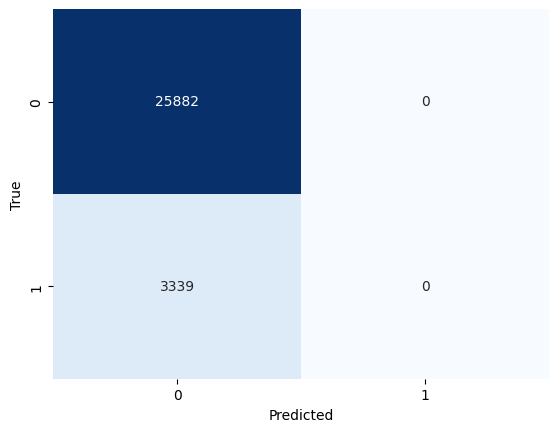

457/457 [==============================] - 1s 2ms/step
              precision    recall  f1-score       support
0              0.885733  1.000000  0.939404  25882.000000
1              0.000000  0.000000  0.000000   3339.000000
accuracy       0.885733  0.885733  0.885733      0.885733
macro avg      0.442866  0.500000  0.469702  29221.000000
weighted avg   0.784523  0.885733  0.832061  29221.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
confusion_matrix_plot(model_0, train_gen, save_file='models/evaluate/model_0_train_confusion_matrix.pdf')
classification_report_output(model_0, train_gen, save_file=None)
confusion_matrix_plot(model_0, val_gen, save_file='models/evaluate/model_0_val_confusion_matrix.pdf')
classification_report_output(model_0, val_gen, save_file=None)
confusion_matrix_plot(model_0, test_gen, save_file='models/evaluate/model_0_test_confusion_matrix.pdf')
classification_report_output(model_0, test_gen, save_file=None)

In [30]:
# Hyperparameter Tuning
def nn_lstm_hyperparameter_tuning(build_model_fn, 
                                  lstm_units_list, 
                                  weight_penalty_list,
                                  learning_rates_list, 
                                  callback_filepath):
    import numpy as np
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # Placeholder for the best model and its corresponding hyperparameters
    best_model = None
    best_lstm_units = None
    best_learning_rate = None
    best_penalty = None
    best_val_metric = -np.inf  # Set initial value to negative infinity

    # Loop through all combinations of LSTM units and learning rates
    for lstm_units in lstm_units_list:
        for learning_rate in learning_rates_list:
          for weight_penalty in weight_penalty_list:
            # Display the variables
            print(f'lstm_units: {lstm_units}, learning_rate: {learning_rate}, weight_penalty: {weight_penalty}')
            
            # Build model
            model = build_model_fn(lstm_units, learning_rate)

            # Set weight penalty
            class_weights_dict[1] = class_weights_dict[1] * weight_penalty         

            # Train the model on the training set
            history = model.fit(train_gen, 
                                shuffle=False,
                                validation_data=val_gen, 
                                epochs=epochs, 
                                class_weight=class_weights_dict,
                                callbacks=callbacks(callback_filepath,
                                                    patience=5))

            # Evaluate the model on the validation set
            y_val_true = np.concatenate([y for x, y in val_gen], axis=0)
            y_val_pred_probs = model.predict(val_gen)
            y_val_pred = (y_val_pred_probs > 0.5).astype(int)

            # Calculate the performance metric(s) of interest (e.g., F1-score)
            val_f1_score = f1_score(y_val_true, y_val_pred)

            # Update the best model and hyperparameters if the current model is better
            if val_f1_score > best_val_metric:
                best_history = history
                best_val_metric = val_f1_score
                best_model = model
                best_lstm_units = lstm_units
                best_learning_rate = learning_rate
                best_penalty = weight_penalty

    # Print the best LSTM units and learning rate
    print(f"Best LSTM units: {best_lstm_units}")
    print(f"Best learning rate: {best_learning_rate}")
    print(f"Best weight_penalty: {best_penalty}")

    return history, best_model, best_lstm_units, best_learning_rate, best_penalty


In [31]:
def build_lstm_model(lstm_units, learning_rate):
    from tensorflow import keras
    from tensorflow.keras.optimizers import Adam
    from keras.layers import Dense, LSTM

    inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))
    x = LSTM(units=lstm_units, 
          activation='tanh', 
          dropout=0.5)(inputs)
    outputs = Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.summary()

    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['binary_accuracy'])

    return model

In [32]:
# Parameters for fitting and saving model training data
epochs = 200
model_1_filepath = 'models/model_1_lstm.keras'
history_1_filepath = 'models/trainHistoryDict/model_1_lstm_history.pkl'

In [33]:

lstm_units_list = [32, 64]
learning_rates_list = [0.0001, 0.001, 0.01, 0.1]
class_weight_penalty= [1, 2, 10]
# Fit the model to the training data

history_1, model_1, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                                      build_lstm_model,
                                                                      lstm_units_list,
                                                                      class_weight_penalty,
                                                                      learning_rates_list,
                                                                      model_1_filepath)

# Pickle the Traning Fit History
with open(history_1_filepath, 'wb') as file_pi:
    pickle.dump(history_1, file_pi)

lstm_units: 32, learning_rate: 0.0001, weight_penalty: 1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 600, 6)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                4992      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
696/696 [==============================] - 16s 19ms/step - loss: 0.6922 - binary_accuracy: 0.4052 - val_loss: 0.6367 - val_binary_accuracy: 0.8840
Epoch 2/200
696/696 [==============================] - 12s 17ms/step - loss: 0.6920 - binary_accuracy: 0.51

164/164 [==============================] - 2s 11ms/step - loss: 11.0550 - binary_accuracy: 0.1097


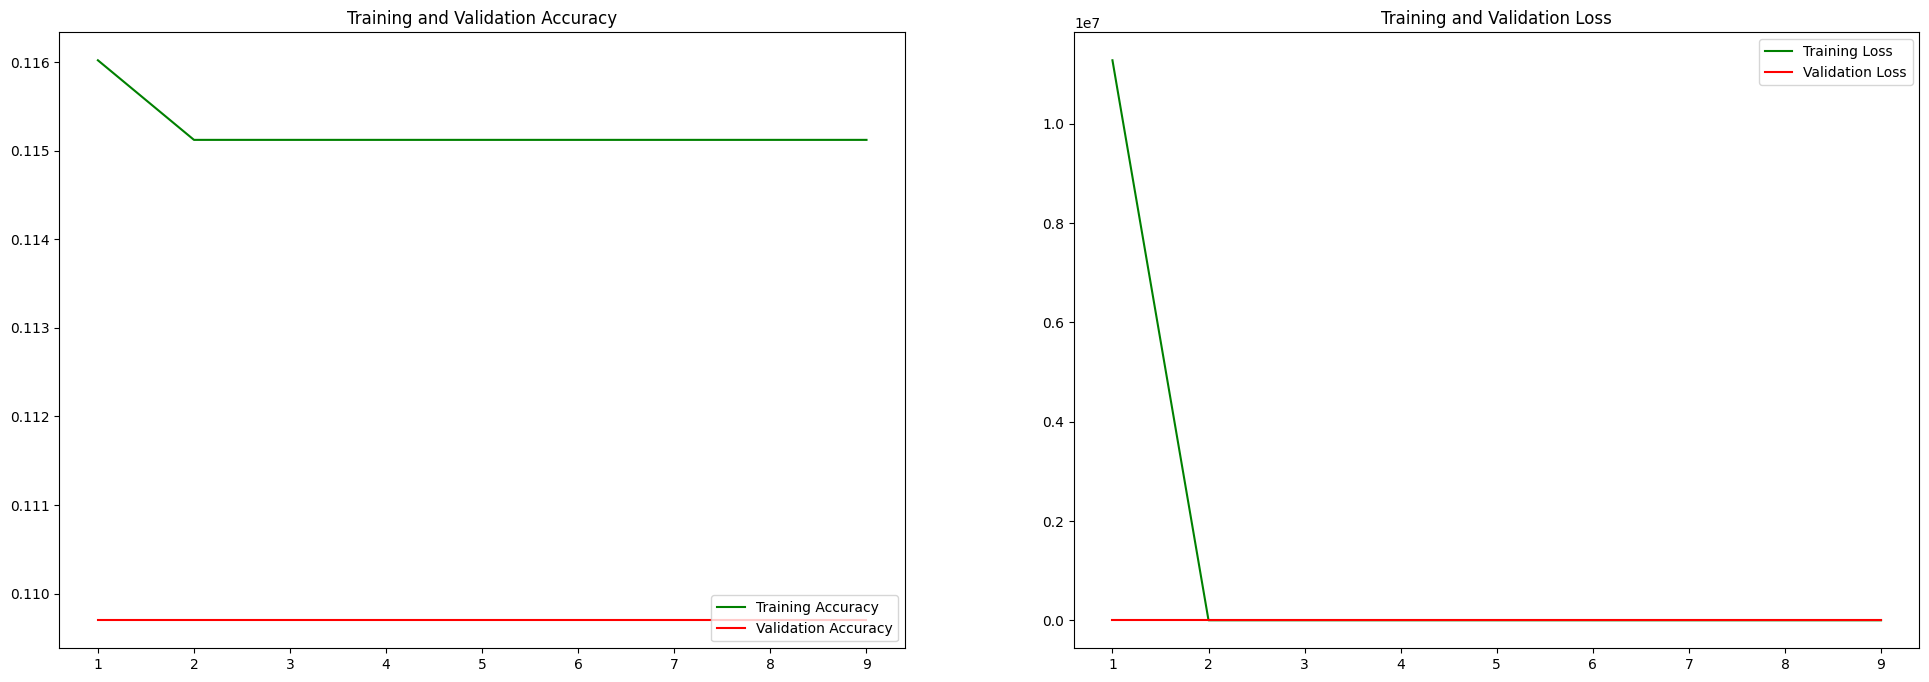

Validation Binary Accuracy is: 0.11
457/457 [==============================] - 5s 10ms/step - loss: 8.5359 - binary_accuracy: 0.1143
Testing Binary Accuracy is: 0.11


In [34]:
# Load and Evaluate Model
model_1, history_1 = evaluate_model(model_1_filepath, 
                         history_1_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_1_evaluation.pdf')

696/696 [==============================] - 7s 10ms/step


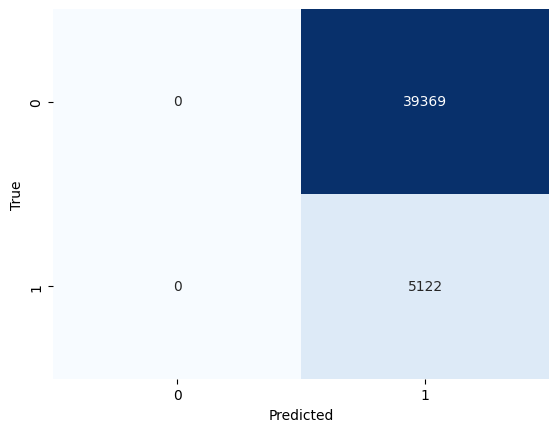

696/696 [==============================] - 7s 10ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  39369.000000
1              0.115124  1.000000  0.206478   5122.000000
accuracy       0.115124  0.115124  0.115124      0.115124
macro avg      0.057562  0.500000  0.103239  44491.000000
weighted avg   0.013254  0.115124  0.023771  44491.000000
  6/164 [>.............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


164/164 [==============================] - 2s 10ms/step


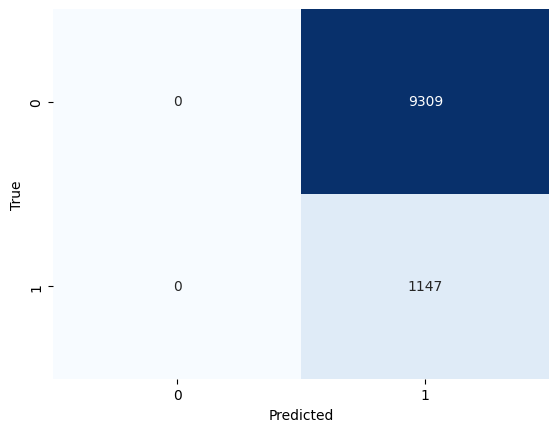

164/164 [==============================] - 2s 10ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000   9309.000000
1              0.109698  1.000000  0.197707   1147.000000
accuracy       0.109698  0.109698  0.109698      0.109698
macro avg      0.054849  0.500000  0.098854  10456.000000
weighted avg   0.012034  0.109698  0.021688  10456.000000
 12/457 [..............................] - ETA: 4s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


457/457 [==============================] - 5s 10ms/step


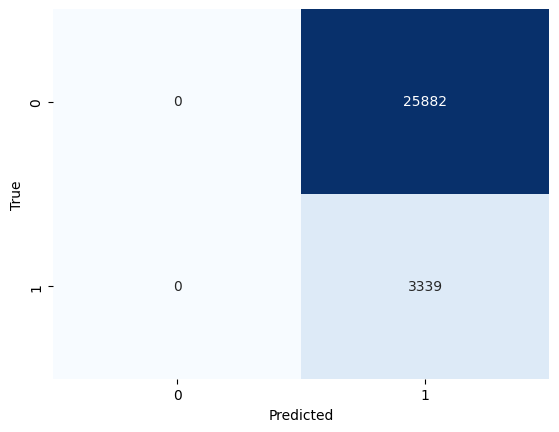

457/457 [==============================] - 5s 10ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  25882.000000
1              0.114267  1.000000  0.205098   3339.000000
accuracy       0.114267  0.114267  0.114267      0.114267
macro avg      0.057134  0.500000  0.102549  29221.000000
weighted avg   0.013057  0.114267  0.023436  29221.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
confusion_matrix_plot(model_1, train_gen, save_file='models/evaluate/model_1_train_confusion_matrix.pdf')
classification_report_output(model_1, train_gen, save_file=None)
confusion_matrix_plot(model_1, val_gen, save_file='models/evaluate/model_1_val_confusion_matrix.pdf')
classification_report_output(model_1, val_gen, save_file=None)
confusion_matrix_plot(model_1, test_gen, save_file='models/evaluate/model_1_test_confusion_matrix.pdf')
classification_report_output(model_1, test_gen, save_file=None)

In [35]:
def build_lstm_2_model(lstm_units, learning_rate):
    import keras
    from keras.layers import LSTM, Dense
    from keras.models import Sequential
    from tensorflow.keras.optimizers import Adam

    # Build the model
    inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

    # LSTM layer
    x = LSTM(lstm_units, 
            activation='tanh', 
            input_shape=(seq_length, train_gen[0][0].shape[2]),
             return_sequences = True,
            dropout=0.5)(inputs) # Dropout
    # Second LSTM Layer
    x = LSTM(lstm_units//2, 
            activation='tanh', 
            dropout=0.5)(x) # Dropout
    outputs = Dense(1, 'sigmoid')(x)
    model = keras.Model(inputs, outputs)

    # Compile
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['binary_accuracy'])

    model.summary()

    return model

In [36]:
model_2_filepath = 'models/model_2_multiLSTM.keras'
history_2_filepath = 'models/trainHistoryDict/model_2_dense_history.pkl'
lstm_units_list = [best_lstm_units]
learning_rates_list = [best_learning_rate]
class_weight_penalty= [best_penalty]

In [37]:
print(lstm_units_list)
print(learning_rates_list)
print(class_weight_penalty)

[32]
[0.0001]
[2]


In [38]:
# Fit the model to the training data
history_2, model_2, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_2_model,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_2_filepath)
# Pickle the Traning Fit History
with open(history_2_filepath, 'wb') as file_pi:
    pickle.dump(history_2, file_pi)

lstm_units: 32, learning_rate: 0.0001, weight_penalty: 2
Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 600, 6)]          0         
                                                                 
 lstm_24 (LSTM)              (None, 600, 32)           4992      
                                                                 
 lstm_25 (LSTM)              (None, 16)                3136      
                                                                 
 dense_26 (Dense)            (None, 1)                 17        
                                                                 
Total params: 8,145
Trainable params: 8,145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
696/696 [==============================] - 26s 32ms/step - loss: 4621971968.0000 - binary_accuracy: 0.1178 - val_loss: 

164/164 [==============================] - 3s 15ms/step - loss: 3.6098 - binary_accuracy: 0.1097


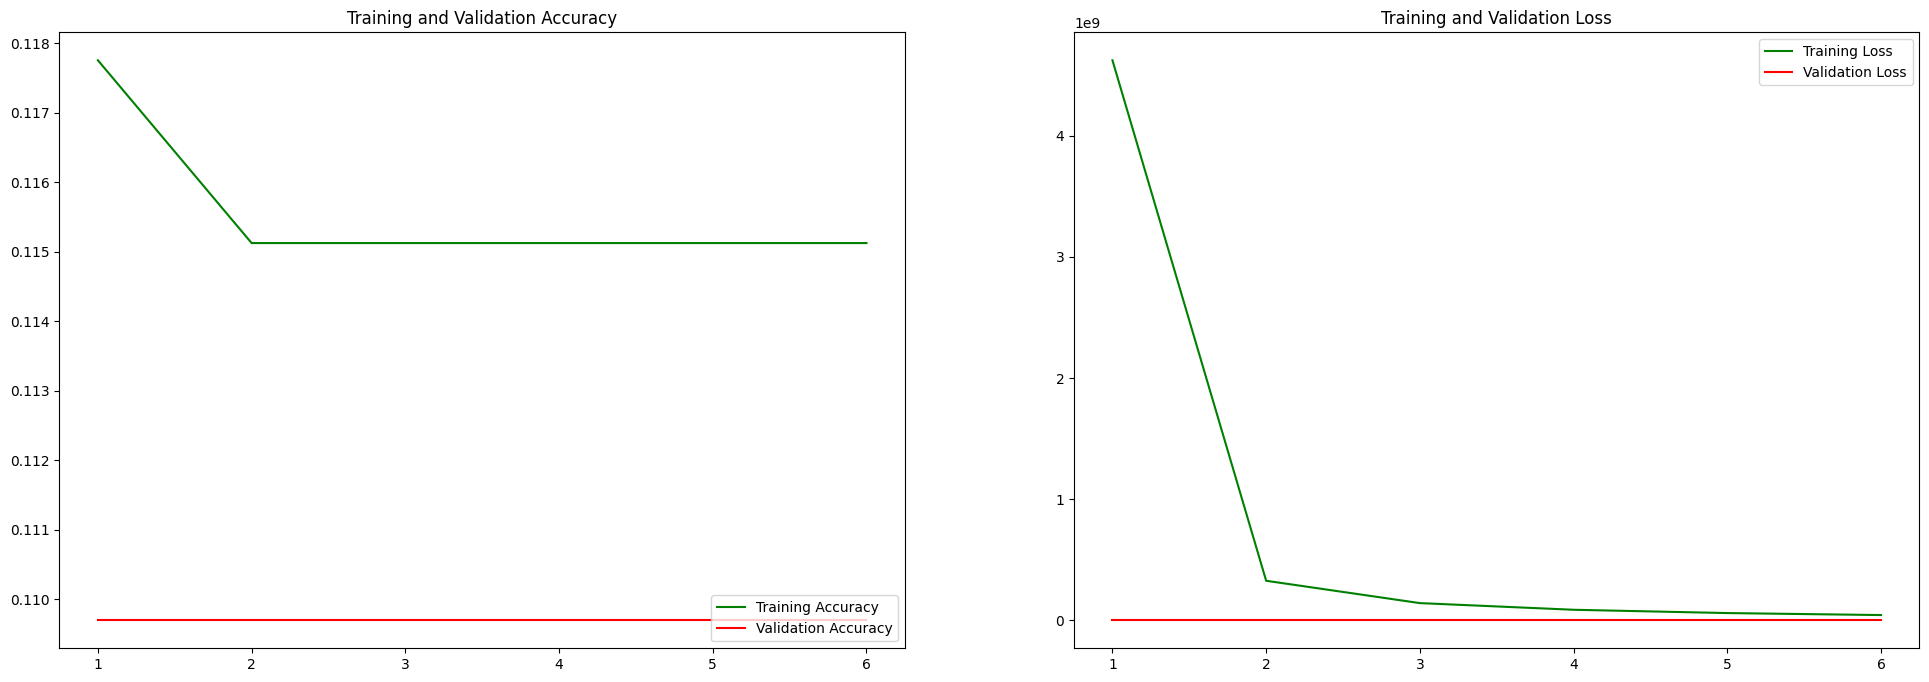

Validation Binary Accuracy is: 0.11
457/457 [==============================] - 7s 14ms/step - loss: 3.6058 - binary_accuracy: 0.1143
Testing Binary Accuracy is: 0.11


In [39]:
# Load and Evaluate Model
model_2, history_2 = evaluate_model(model_2_filepath, 
                         history_2_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_2_evaluation.pdf')

696/696 [==============================] - 9s 12ms/step


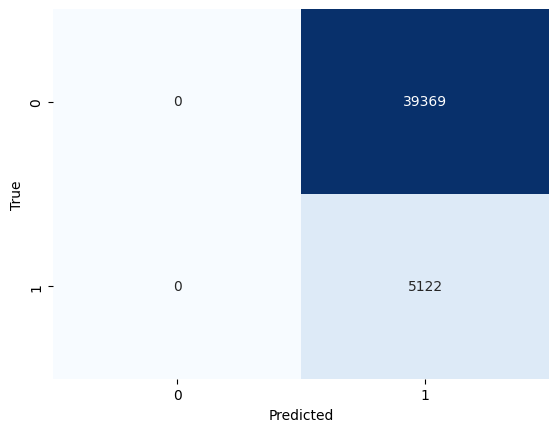

696/696 [==============================] - 8s 12ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  39369.000000
1              0.115124  1.000000  0.206478   5122.000000
accuracy       0.115124  0.115124  0.115124      0.115124
macro avg      0.057562  0.500000  0.103239  44491.000000
weighted avg   0.013254  0.115124  0.023771  44491.000000
  5/164 [..............................] - ETA: 2s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


164/164 [==============================] - 2s 12ms/step


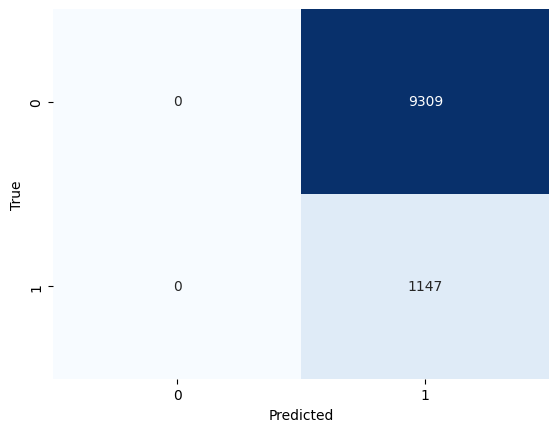

164/164 [==============================] - 2s 13ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000   9309.000000
1              0.109698  1.000000  0.197707   1147.000000
accuracy       0.109698  0.109698  0.109698      0.109698
macro avg      0.054849  0.500000  0.098854  10456.000000
weighted avg   0.012034  0.109698  0.021688  10456.000000
  9/457 [..............................] - ETA: 5s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


457/457 [==============================] - 5s 12ms/step


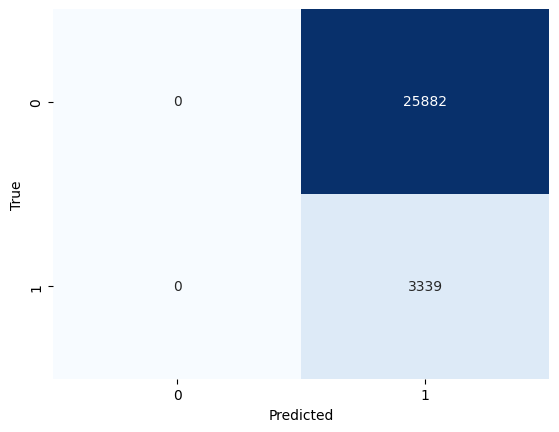

457/457 [==============================] - 6s 12ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  25882.000000
1              0.114267  1.000000  0.205098   3339.000000
accuracy       0.114267  0.114267  0.114267      0.114267
macro avg      0.057134  0.500000  0.102549  29221.000000
weighted avg   0.013057  0.114267  0.023436  29221.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
confusion_matrix_plot(model_2, train_gen, save_file='models/evaluate/model_2_train_confusion_matrix.pdf')
classification_report_output(model_2, train_gen, save_file=None)
confusion_matrix_plot(model_2, val_gen, save_file='models/evaluate/model_2_val_confusion_matrix.pdf')
classification_report_output(model_2, val_gen, save_file=None)
confusion_matrix_plot(model_2, test_gen, save_file='models/evaluate/model_2_test_confusion_matrix.pdf')
classification_report_output(model_2, test_gen, save_file=None)

In [41]:
# Model 3
def build_lstm_2_norm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Dropout
  from tensorflow.keras.optimizers import Adam
  from keras.layers.normalization.batch_normalization_v1 import BatchNormalization

  # Build the model
  inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

  # LSTM layer
  x = LSTM(lstm_units, 
          activation='tanh', 
          input_shape=(seq_length, train_gen[0][0].shape[2]),
          return_sequences=True,
          dropout=0.5)(inputs) # Dropout
  # Second LSTM Layer
  x = BatchNormalization()(x)
  x = LSTM(lstm_units//2, 
          activation='tanh', 
          return_sequences=False,  # Set return_sequences=False
          dropout=0.5)(x) # Dropout
  x = BatchNormalization()(x)
  # Dense layer for binary prediction
  outputs = Dense(1, activation='sigmoid')(x)

  model = keras.Model(inputs, outputs)

  # Compile
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate=learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model

In [42]:
model_3_filepath = 'models/model_3_multiLSTM.keras'
history_3_filepath = 'models/trainHistoryDict/model_3_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.0001, 0.001, 0.01, 0.1]
#class_weight_penalty = [1, 2, 10, 100, 1000]

In [43]:
# Fit the model and tune hyperparameters
history_3, model_3, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_2_norm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_3_filepath)
# Pickle the Training Fit History
with open(history_3_filepath, 'wb') as file_pi:
    pickle.dump(history_3, file_pi)

lstm_units: 32, learning_rate: 0.0001, weight_penalty: 2
Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 600, 6)]          0         
                                                                 
 lstm_26 (LSTM)              (None, 600, 32)           4992      
                                                                 
 batch_normalization (BatchN  (None, 600, 32)          128       
 ormalization)                                                   
                                                                 
 lstm_27 (LSTM)              (None, 16)                3136      
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 

164/164 [==============================] - 3s 15ms/step - loss: 1.5288 - binary_accuracy: 0.2504


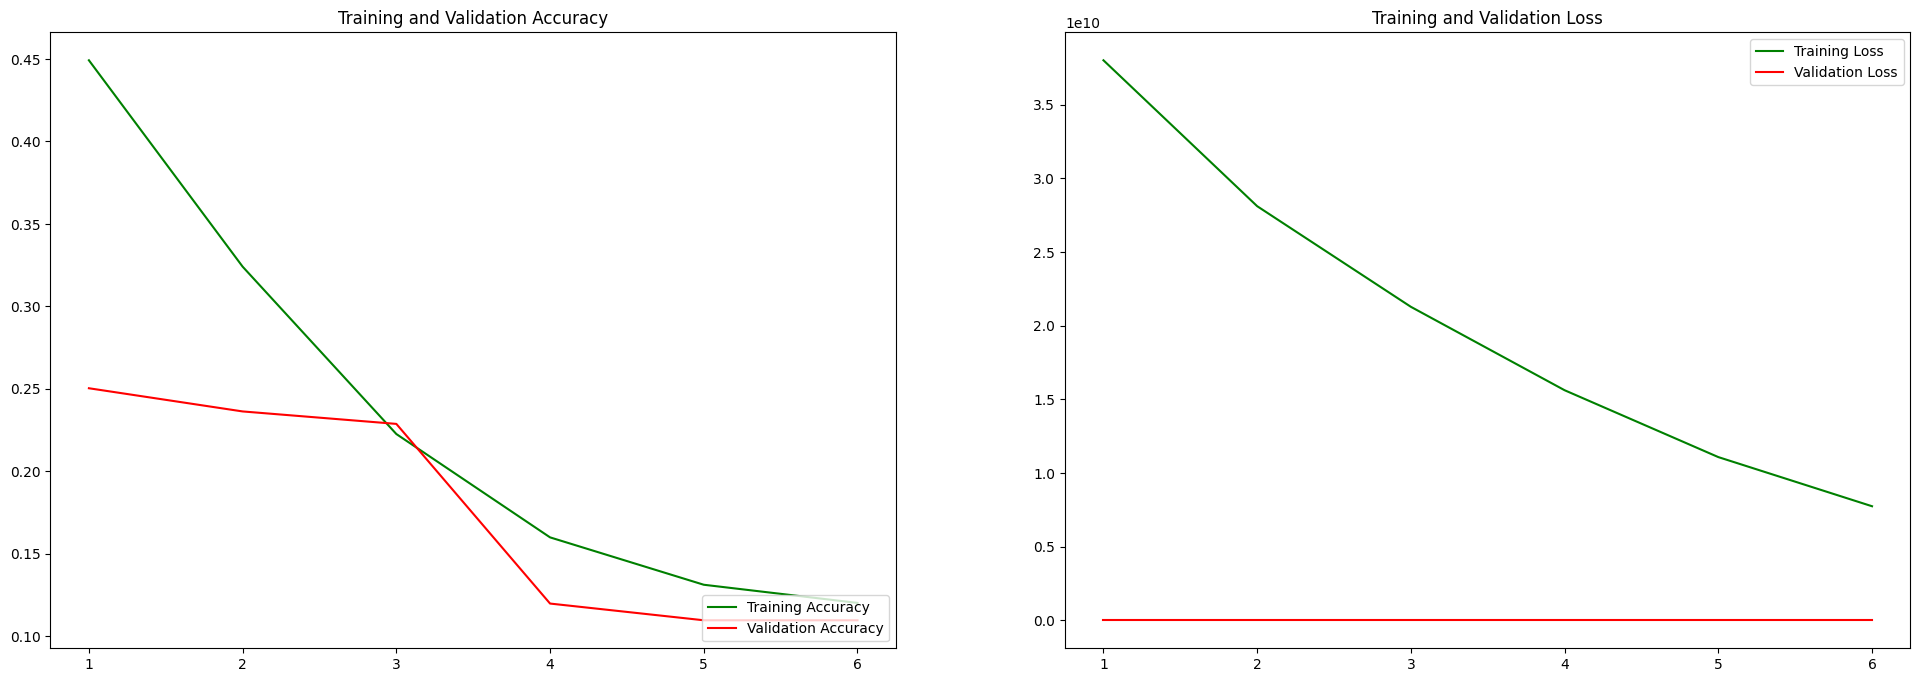

Validation Binary Accuracy is: 0.25
457/457 [==============================] - 7s 15ms/step - loss: 0.9656 - binary_accuracy: 0.5890
Testing Binary Accuracy is: 0.59


In [44]:
# Load and Evaluate Model
model_3, history_3 = evaluate_model(model_3_filepath, 
                         history_3_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_3_evaluation.pdf')

696/696 [==============================] - 9s 12ms/step


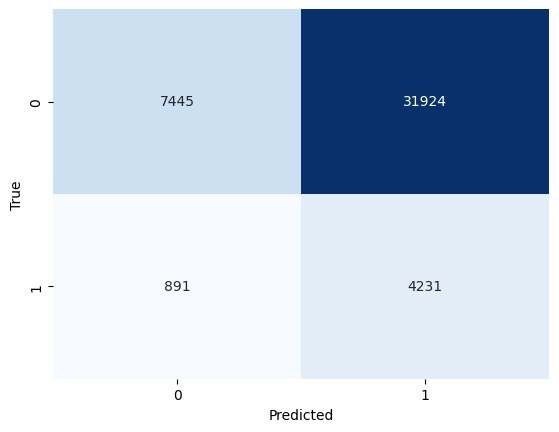

696/696 [==============================] - 9s 12ms/step
              precision    recall  f1-score       support
0              0.893114  0.189108  0.312127  39369.000000
1              0.117024  0.826045  0.205005   5122.000000
accuracy       0.262435  0.262435  0.262435      0.262435
macro avg      0.505069  0.507576  0.258566  44491.000000
weighted avg   0.803767  0.262435  0.299794  44491.000000
164/164 [==============================] - 2s 12ms/step


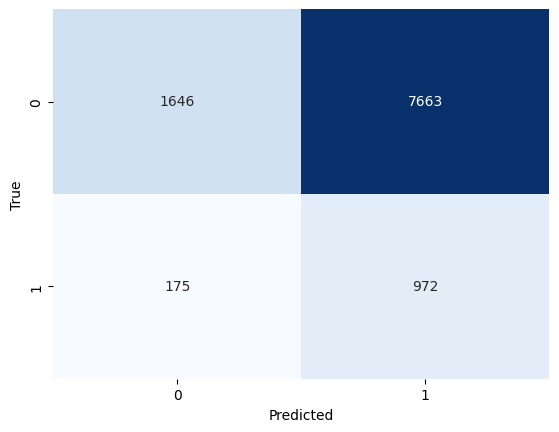

164/164 [==============================] - 2s 12ms/step
              precision    recall  f1-score       support
0              0.903899  0.176818  0.295777   9309.000000
1              0.112565  0.847428  0.198732   1147.000000
accuracy       0.250383  0.250383  0.250383      0.250383
macro avg      0.508232  0.512123  0.247255  10456.000000
weighted avg   0.817091  0.250383  0.285132  10456.000000
457/457 [==============================] - 6s 12ms/step


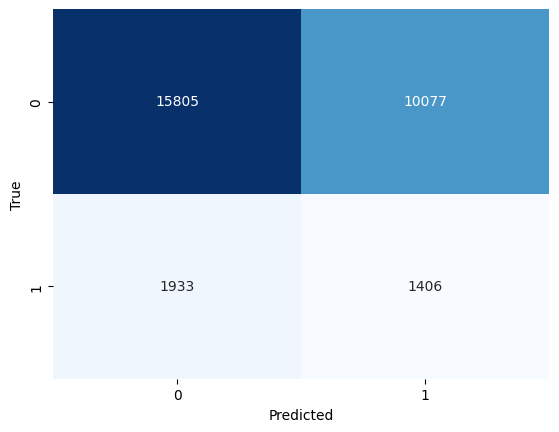

457/457 [==============================] - 6s 12ms/step
              precision    recall  f1-score       support
0              0.891025  0.610656  0.724668  25882.000000
1              0.122442  0.421084  0.189718   3339.000000
accuracy       0.588994  0.588994  0.588994      0.588994
macro avg      0.506733  0.515870  0.457193  29221.000000
weighted avg   0.803201  0.588994  0.663540  29221.000000


In [45]:
confusion_matrix_plot(model_3, train_gen, save_file='models/evaluate/model_3_train_confusion_matrix.pdf')
classification_report_output(model_3, train_gen, save_file=None)
confusion_matrix_plot(model_3, val_gen, save_file='models/evaluate/model_3_val_confusion_matrix.pdf')
classification_report_output(model_3, val_gen, save_file=None)
confusion_matrix_plot(model_3, test_gen, save_file='models/evaluate/model_3_test_confusion_matrix.pdf')
classification_report_output(model_3, test_gen, save_file=None)

In [46]:
def build_lstm_conv_lstm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
  from tensorflow.keras.optimizers import Adam

  # Define the input shape
  inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

  # Add a 1D convolutional layer to extract features
  x = Conv1D(filters=9, kernel_size=9, activation='relu', padding='same')(inputs)
  x = MaxPooling1D(pool_size=2)(x)
  x = Conv1D(filters=9, kernel_size=3, activation='relu', padding='same')(x)
  x = MaxPooling1D(pool_size=2)(x)

  # LSTM layer
  x = LSTM(27, activation='tanh', return_sequences=True)(x)

  # Flatten the output
  x = Flatten()(x)

  # Dense layer
  x = Dense(lstm_units//2, activation='relu')(x)

  # Dropout layer
  x = Dropout(0.5)(x)

  # Add the output layer
  outputs = Dense(1, activation='sigmoid')(x)

  # Create the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model


In [47]:
# Parameters for fitting and saving model training data
epochs = 200
model_4_filepath = 'models/model_4_conv_lstm.keras'
history_4_filepath = 'models/trainHistoryDict/model_4_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.01]

In [48]:
# Fit the model and tune hyperparameters
history_4, model_4, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_lstm_conv_lstm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_4_filepath)
# Pickle the Training Fit History
with open(history_4_filepath, 'wb') as file_pi:
    pickle.dump(history_4, file_pi)

lstm_units: 32, learning_rate: 0.01, weight_penalty: 2
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 600, 6)]          0         
                                                                 
 conv1d (Conv1D)             (None, 600, 9)            495       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 300, 9)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 300, 9)            252       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 150, 9)           0         
 1D)                                                             
                                                                 
 ls

164/164 [==============================] - 2s 7ms/step - loss: 52.1290 - binary_accuracy: 0.1097


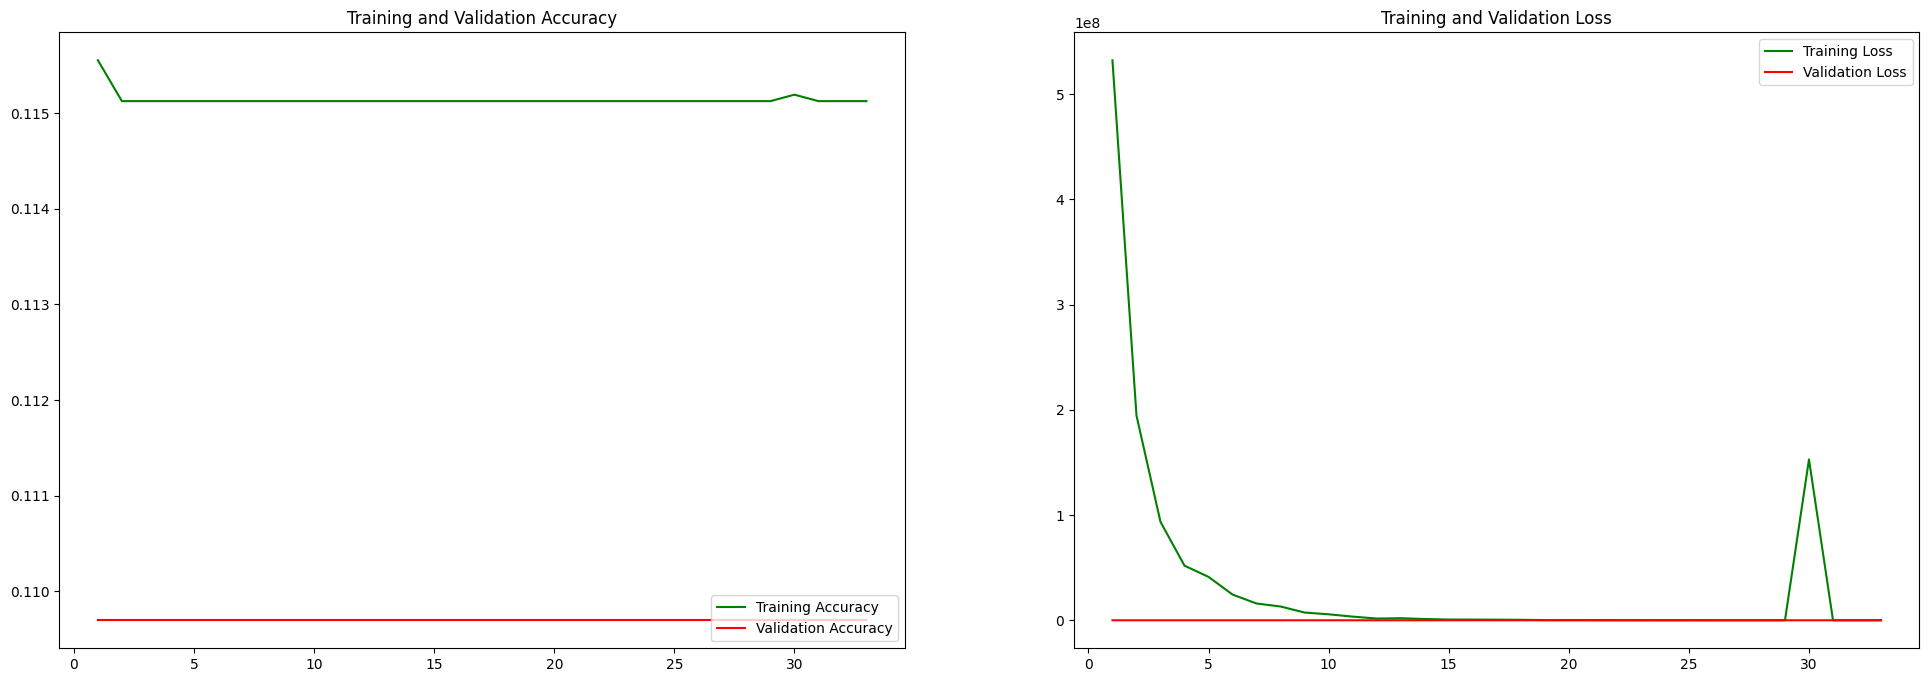

Validation Binary Accuracy is: 0.11
457/457 [==============================] - 3s 7ms/step - loss: 50.9222 - binary_accuracy: 0.1143
Testing Binary Accuracy is: 0.11


In [49]:
# Load and Evaluate Model
model_4, history_4 = evaluate_model(model_4_filepath, 
                         history_4_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_4_evaluation.pdf')

696/696 [==============================] - 3s 4ms/step


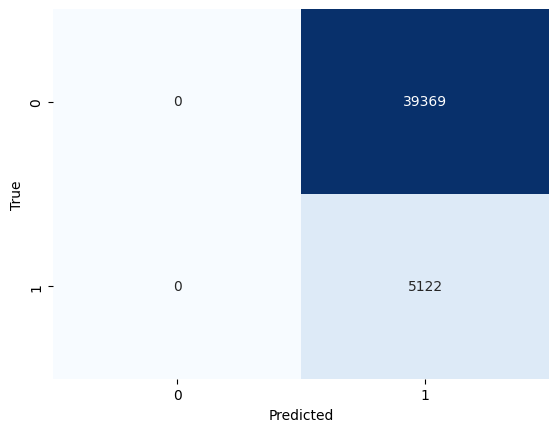

696/696 [==============================] - 3s 4ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  39369.000000
1              0.115124  1.000000  0.206478   5122.000000
accuracy       0.115124  0.115124  0.115124      0.115124
macro avg      0.057562  0.500000  0.103239  44491.000000
weighted avg   0.013254  0.115124  0.023771  44491.000000
 16/164 [=>............................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


164/164 [==============================] - 1s 4ms/step


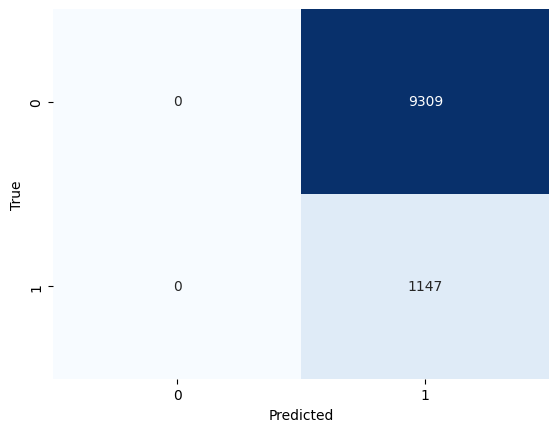

164/164 [==============================] - 1s 4ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000   9309.000000
1              0.109698  1.000000  0.197707   1147.000000
accuracy       0.109698  0.109698  0.109698      0.109698
macro avg      0.054849  0.500000  0.098854  10456.000000
weighted avg   0.012034  0.109698  0.021688  10456.000000
 30/457 [>.............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


457/457 [==============================] - 2s 4ms/step


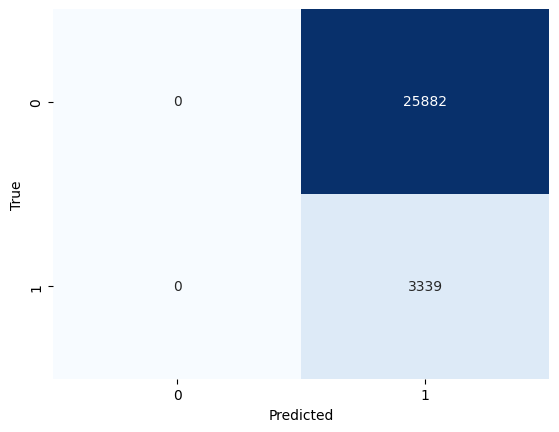

457/457 [==============================] - 2s 4ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  25882.000000
1              0.114267  1.000000  0.205098   3339.000000
accuracy       0.114267  0.114267  0.114267      0.114267
macro avg      0.057134  0.500000  0.102549  29221.000000
weighted avg   0.013057  0.114267  0.023436  29221.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
confusion_matrix_plot(model_4, train_gen, save_file='models/evaluate/model_4_train_confusion_matrix.pdf')
classification_report_output(model_4, train_gen, save_file=None)
confusion_matrix_plot(model_4, val_gen, save_file='models/evaluate/model_4_val_confusion_matrix.pdf')
classification_report_output(model_4, val_gen, save_file=None)
confusion_matrix_plot(model_4, test_gen, save_file='models/evaluate/model_4_test_confusion_matrix.pdf')
classification_report_output(model_4, test_gen, save_file=None)

In [55]:
def build_cpx_lstm_model_norm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Flatten, BatchNormalization
  from tensorflow.keras.optimizers import Adam

  # Define the input shape
  inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

  x = LSTM(lstm_units, 
        activation='tanh', 
        input_shape=(seq_length, train_gen[0][0].shape[2]),
        return_sequences=True)(inputs)

  x = LSTM(lstm_units//2, 
        activation='tanh', 
        input_shape=(seq_length, train_gen[0][0].shape[2]),
        return_sequences=True,
        dropout=0.5)(x) # Dropout

  x = BatchNormalization()(x)

  x = LSTM(lstm_units//2, 
        activation='tanh', 
        input_shape=(seq_length, train_gen[0][0].shape[2]),
        return_sequences=True,
        dropout=0.5)(x) # Dropout

  x = BatchNormalization()(x)

  outputs = TimeDistributed(Dense(1, activation='sigmoid'))(x)

  # Build the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model

In [64]:
# Parameters for fitting and saving model training data
epochs = 200
model_5_filepath = 'models/model_4_conv_lstm.keras'
history_5_filepath = 'models/trainHistoryDict/model_4_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.0001, 0.001, 0.01, 0.1]
class_weight_penalty= [1]# [1, 2, 10, 100, 1000]

In [65]:
for i in range(len(train_gen)):
    batch = train_gen[i]
    target_batch = batch[1]
    if not all(val in [0, 1] for val in target_batch):
        print(f"Target variable in batch {i} is not binary.")


In [66]:
# Fit the model and tune hyperparameters
history_5, model_5, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_cpx_lstm_model_norm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_5_filepath)
# Pickle the Training Fit History
with open(history_5_filepath, 'wb') as file_pi:
    pickle.dump(history_5, file_pi)

lstm_units: 32, learning_rate: 0.01, weight_penalty: 1
Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 600, 6)]          0         
                                                                 
 lstm_34 (LSTM)              (None, 600, 32)           4992      
                                                                 
 lstm_35 (LSTM)              (None, 600, 16)           3136      
                                                                 
 batch_normalization_4 (Batc  (None, 600, 16)          64        
 hNormalization)                                                 
                                                                 
 lstm_36 (LSTM)              (None, 600, 16)           2112      
                                                                 
 batch_normalization_5 (Batc  (None, 600, 16)          64        
 hN

ValueError: ignored

In [67]:
# Get the unique values of the 'label' column
label_values = df['label'].unique()

# Check if there are values other than 0 and 1 in the 'label' column
if set(label_values) - {0, 1}:
    print("The 'label' column contains values other than 0 and 1")
else:
    print("The 'label' column contains only 0 and 1")

The 'label' column contains only 0 and 1


In [ ]:
# Load and Evaluate Model
model_5, history_5 = evaluate_model(model_5_filepath, 
                         history_5_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_5_evaluation.pdf')

In [ ]:
confusion_matrix_plot(model_5, train_gen, save_file='models/evaluate/model_5_train_confusion_matrix.pdf')
classification_report_output(model_5, train_gen, save_file=None)
confusion_matrix_plot(model_5, val_gen, save_file='models/evaluate/model_5_val_confusion_matrix.pdf')
classification_report_output(model_5, val_gen, save_file=None)
confusion_matrix_plot(model_5, test_gen, save_file='models/evaluate/model_5_test_confusion_matrix.pdf')
classification_report_output(model_5, test_gen, save_file=None)

In [68]:
# Model 6: Bidirectional LSTM
def build_bidirection_lstm(lstm_units, learning_rate):
  import keras
  from keras.layers import LSTM, Dense, Bidirectional
  from tensorflow.keras.optimizers import Adam

  # Define the input shape
  inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

  # Next model add a Dense layer here
  x = Bidirectional(LSTM(lstm_units, 
                         activation='tanh', 
                         return_sequences=True,
                         dropout=0.5))(inputs)
  x = Bidirectional(LSTM(lstm_units, 
                         activation='tanh', 
                         #return_sequences=True,
                         dropout=0.5))(x)
  x = Dense(units=batch_size//2, 
            activation='relu')(x)

  outputs = Dense(units=1, activation='sigmoid')(x)

  # Build the model
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model
  model.compile(loss='binary_crossentropy', 
                optimizer=Adam(learning_rate), 
                metrics=['binary_accuracy'])

  model.summary()

  return model

In [69]:
# Parameters for fitting and saving model training data
epochs = 200
model_6_filepath = 'models/model_6_bidirectional.keras'
history_6_filepath = 'models/trainHistoryDict/model_6_history.pkl'
#lstm_units_list = [32, 64, 128]
#learning_rates_list = [0.0001, 0.001, 0.01, 0.1]
class_weight_penalty= [1] #[1, 2, 10, 100, 1000]

In [70]:
# Fit the model and tune hyperparameters
history_6, model_6, best_lstm_units, best_learning_rate, best_penalty = nn_lstm_hyperparameter_tuning(
                                                          build_bidirection_lstm,
                                                          lstm_units_list,
                                                          class_weight_penalty,
                                                          learning_rates_list,
                                                          model_6_filepath)
# Pickle the Training Fit History
with open(history_6_filepath, 'wb') as file_pi:
    pickle.dump(history_6, file_pi)

lstm_units: 32, learning_rate: 0.01, weight_penalty: 1
Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 600, 6)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 600, 64)          9984      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dense_33 (Dense)            (None, 1)                 33        
                                                                 
Tot

164/164 [==============================] - 6s 25ms/step - loss: 16.1477 - binary_accuracy: 0.1097


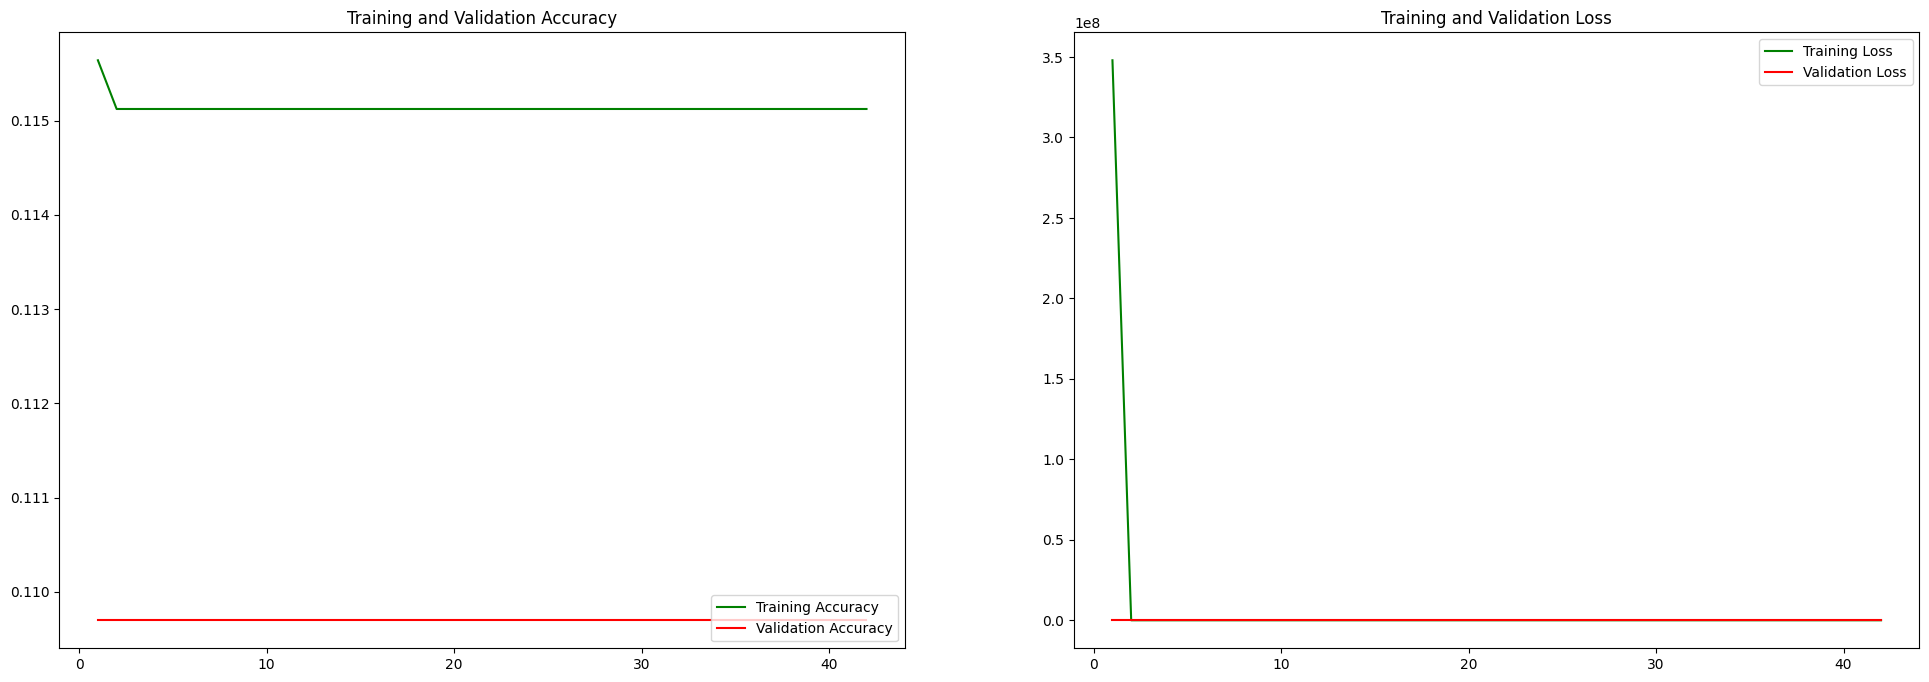

Validation Binary Accuracy is: 0.11
457/457 [==============================] - 12s 25ms/step - loss: 14.1949 - binary_accuracy: 0.1143
Testing Binary Accuracy is: 0.11


In [71]:
# Fit the model to the training data
# Load and Evaluate Model
model_6, history_6 = evaluate_model(model_6_filepath, 
                         history_6_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_6_evaluation.pdf')

696/696 [==============================] - 17s 23ms/step


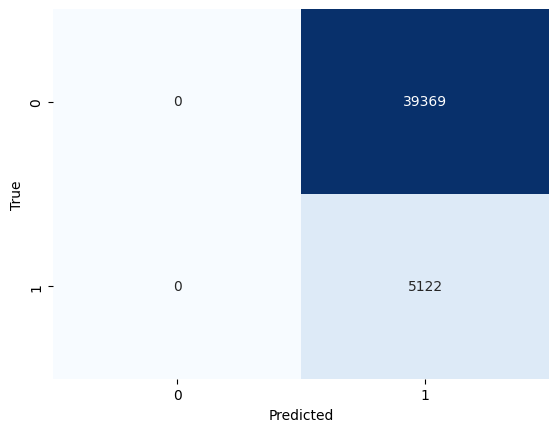

696/696 [==============================] - 16s 23ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  39369.000000
1              0.115124  1.000000  0.206478   5122.000000
accuracy       0.115124  0.115124  0.115124      0.115124
macro avg      0.057562  0.500000  0.103239  44491.000000
weighted avg   0.013254  0.115124  0.023771  44491.000000
  4/164 [..............................] - ETA: 3s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


164/164 [==============================] - 4s 23ms/step


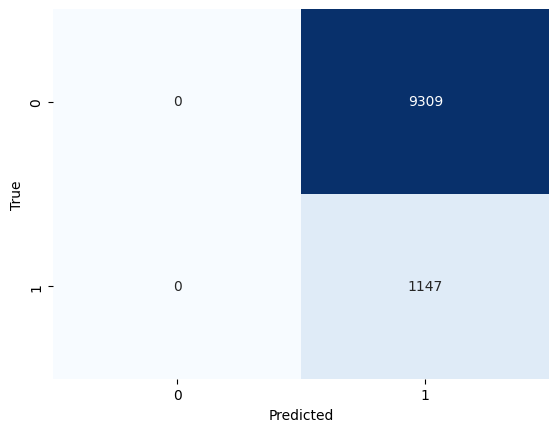

164/164 [==============================] - 4s 24ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000   9309.000000
1              0.109698  1.000000  0.197707   1147.000000
accuracy       0.109698  0.109698  0.109698      0.109698
macro avg      0.054849  0.500000  0.098854  10456.000000
weighted avg   0.012034  0.109698  0.021688  10456.000000
  4/457 [..............................] - ETA: 10s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


457/457 [==============================] - 11s 23ms/step


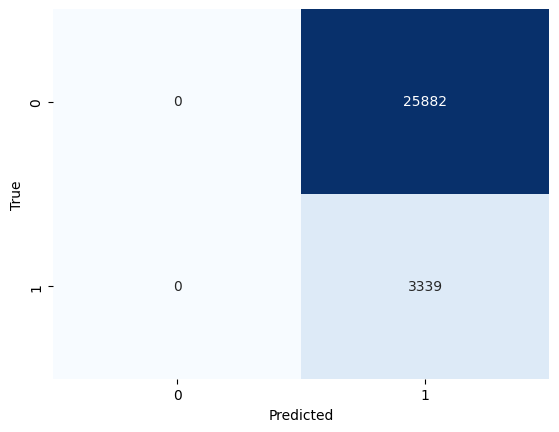

457/457 [==============================] - 10s 23ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  25882.000000
1              0.114267  1.000000  0.205098   3339.000000
accuracy       0.114267  0.114267  0.114267      0.114267
macro avg      0.057134  0.500000  0.102549  29221.000000
weighted avg   0.013057  0.114267  0.023436  29221.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
confusion_matrix_plot(model_6, train_gen, save_file='models/evaluate/model_6_train_confusion_matrix.pdf')
classification_report_output(model_6, train_gen, save_file=None)
confusion_matrix_plot(model_6, val_gen, save_file='models/evaluate/model_6_val_confusion_matrix.pdf')
classification_report_output(model_6, val_gen, save_file=None)
confusion_matrix_plot(model_6, test_gen, save_file='models/evaluate/model_6_test_confusion_matrix.pdf')
classification_report_output(model_6, test_gen, save_file=None)

In [73]:
'''
Model_7: Timeseries classification with a transformer model
Attention is all you need.
'''
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, 
                                  num_heads=num_heads, 
                                  dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(
    input_shape,
    n_classes,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

# Build model
model_7 = build_transformer_model(
                seq_length,
                n_classes=1,
                head_size=256,
                num_heads=4, # Number of Transformer repeats
                ff_dim=4,
                num_transformer_blocks=4,
                mlp_units=[128],
                mlp_dropout=0.4,
                dropout=0.5,
)

# Compile Model
model_7.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=best_learning_rate),
    metrics=["binary_accuracy"],
)
model_7.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 600, 6)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 600, 6)      12          ['input_33[0][0]']               
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 600, 6)      27654       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                           

In [74]:
# Parameters for fitting and saving model training data
epochs = 200
model_7_filepath = 'models/model_7_transformer.keras'
history_7_filepath = 'models/trainHistoryDict/model_7_history.pkl'

In [75]:
# Fit the model to the training data
history_7 = model_7.fit(train_gen, 
                        validation_data=val_gen,
                        shuffle=False, 
                        epochs=epochs, 
                        callbacks=callbacks(model_7_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_7_filepath, 'wb') as file_pi:
    pickle.dump(history_7, file_pi)

Epoch 1/200
696/696 [==============================] - 518s 726ms/step - loss: 0.3691 - binary_accuracy: 0.1151 - val_loss: 0.3453 - val_binary_accuracy: 0.1097
Epoch 2/200
696/696 [==============================] - 503s 723ms/step - loss: 0.3593 - binary_accuracy: 0.1151 - val_loss: 0.3486 - val_binary_accuracy: 0.1097
Epoch 3/200
696/696 [==============================] - 472s 678ms/step - loss: 0.3589 - binary_accuracy: 0.1151 - val_loss: 0.3472 - val_binary_accuracy: 0.1097
Epoch 4/200
696/696 [==============================] - 460s 661ms/step - loss: 0.3565 - binary_accuracy: 0.1151 - val_loss: 0.3473 - val_binary_accuracy: 0.1097
Epoch 5/200
696/696 [==============================] - 460s 661ms/step - loss: 0.3565 - binary_accuracy: 0.1151 - val_loss: 0.3473 - val_binary_accuracy: 0.1097
Epoch 6/200
696/696 [==============================] - 460s 661ms/step - loss: 0.3565 - binary_accuracy: 0.1151 - val_loss: 0.3473 - val_binary_accuracy: 0.1097
Epoch 6: early stopping


164/164 [==============================] - 39s 232ms/step - loss: 0.3453 - binary_accuracy: 0.1097


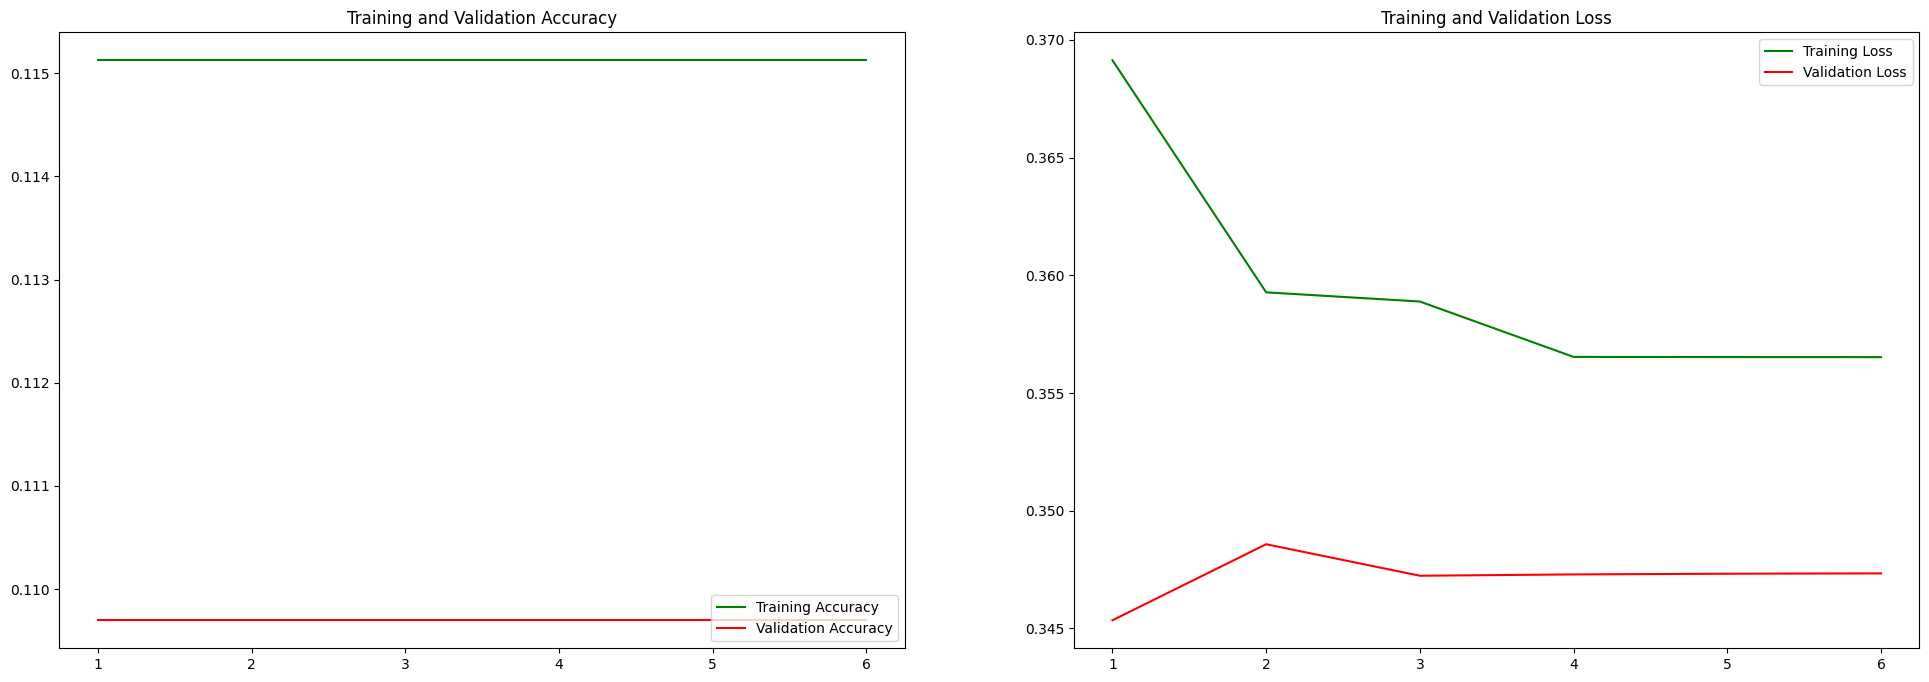

Validation Binary Accuracy is: 0.11
457/457 [==============================] - 105s 230ms/step - loss: 0.3562 - binary_accuracy: 0.1143
Testing Binary Accuracy is: 0.11


In [76]:
# Load and Evaluate Model
model_7, history_7 = evaluate_model(model_7_filepath, 
                         history_7_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_7_evaluation.pdf')

696/696 [==============================] - 161s 231ms/step


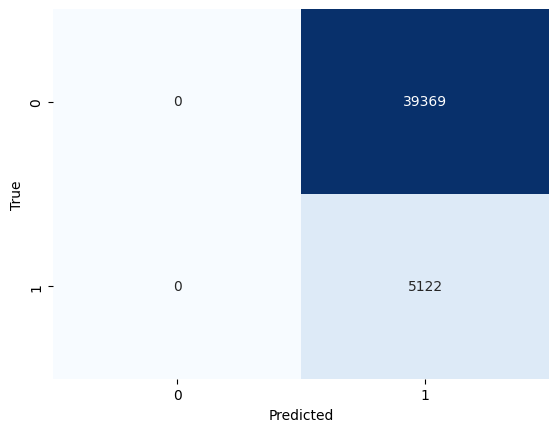

696/696 [==============================] - 161s 231ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  39369.000000
1              0.115124  1.000000  0.206478   5122.000000
accuracy       0.115124  0.115124  0.115124      0.115124
macro avg      0.057562  0.500000  0.103239  44491.000000
weighted avg   0.013254  0.115124  0.023771  44491.000000
  1/164 [..............................] - ETA: 6s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


164/164 [==============================] - 38s 231ms/step


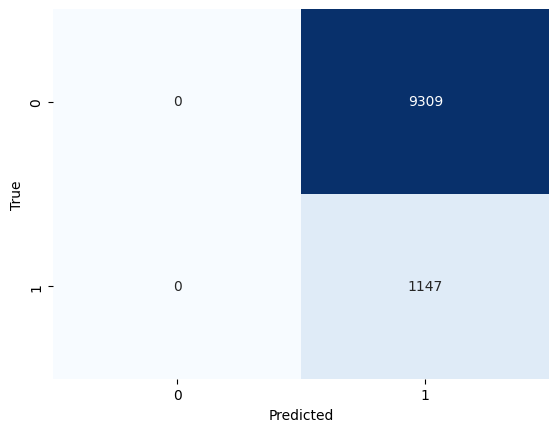

164/164 [==============================] - 38s 231ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000   9309.000000
1              0.109698  1.000000  0.197707   1147.000000
accuracy       0.109698  0.109698  0.109698      0.109698
macro avg      0.054849  0.500000  0.098854  10456.000000
weighted avg   0.012034  0.109698  0.021688  10456.000000
  1/457 [..............................] - ETA: 15s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


457/457 [==============================] - 105s 231ms/step


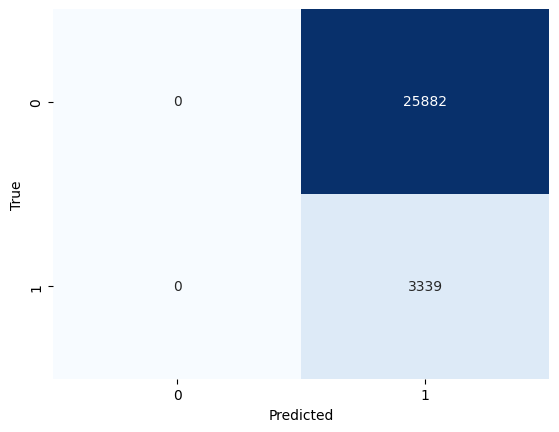

457/457 [==============================] - 105s 231ms/step
              precision    recall  f1-score       support
0              0.000000  0.000000  0.000000  25882.000000
1              0.114267  1.000000  0.205098   3339.000000
accuracy       0.114267  0.114267  0.114267      0.114267
macro avg      0.057134  0.500000  0.102549  29221.000000
weighted avg   0.013057  0.114267  0.023436  29221.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
confusion_matrix_plot(model_7, train_gen, save_file='models/evaluate/model_7_train_confusion_matrix.pdf')
classification_report_output(model_7, train_gen, save_file=None)
confusion_matrix_plot(model_7, val_gen, save_file='models/evaluate/model_7_val_confusion_matrix.pdf')
classification_report_output(model_7, val_gen, save_file=None)
confusion_matrix_plot(model_7, test_gen, save_file='models/evaluate/model_7_test_confusion_matrix.pdf')
classification_report_output(model_7, test_gen, save_file=None)

In [87]:
# XGBoost and Random Forests
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Extract features and labels from the TimeseriesGenerator
X_train = np.concatenate([batch[0] for batch in train_gen])
y_train = np.concatenate([batch[1] for batch in train_gen])

X_val = np.concatenate([batch[0] for batch in val_gen])
y_val = np.concatenate([batch[1] for batch in val_gen])

X_test = np.concatenate([batch[0] for batch in test_gen])
y_test = np.concatenate([batch[1] for batch in test_gen])

# Reshape the data into a 2D format
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_val_2d = X_val.reshape(X_val.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search over
param_grid = {
    'tree_method': ['gpu_hist'],
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5]
}

#Train an XGBoost model:
xgb_model = XGBClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=3, 
    scoring='accuracy',
    verbose=3,
    n_jobs=-1 #all available GPU cores
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_2d, y_train)

# Print the best hyperparameters and the corresponding validation accuracy
print("Best hyperparameters:", grid_search.best_params_)
print("Validation accuracy:", grid_search.best_score_)

y_train_pred = grid_search.predict(X_train_2d)
y_val_pred = grid_search.predict(X_val_2d)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-91-f66cfd700ff9>", line 22, in <cell line: 22>
    grid_search.fit(X_train_2d, y_train)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 874, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
    out = parallel(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 1088, in __call__
    wh

In [90]:
# Print confusion matrix for training set
print("Confusion matrix (training set):\n", confusion_matrix(y_train, y_train_pred))

# Print classification report for training set
print("Classification report (training set):\n", classification_report(y_train, y_train_pred))

# Print confusion matrix for validation set
print("Confusion matrix (validation set):\n", confusion_matrix(y_val, y_val_pred))

# Print classification report for validation set
print("Classification report (validation set):\n", classification_report(y_val, y_val_pred))

Confusion matrix (training set):
 [[39369     0]
 [ 1487  3635]]
Classification report (training set):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     39369
           1       1.00      0.71      0.83      5122

    accuracy                           0.97     44491
   macro avg       0.98      0.85      0.91     44491
weighted avg       0.97      0.97      0.96     44491

Confusion matrix (validation set):
 [[9275   34]
 [1142    5]]
Classification report (validation set):
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      9309
           1       0.13      0.00      0.01      1147

    accuracy                           0.89     10456
   macro avg       0.51      0.50      0.47     10456
weighted avg       0.81      0.89      0.84     10456



In [89]:
#Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_2d, y_train)

y_train_pred = rf_model.predict(X_train_2d)
y_val_pred = rf_model.predict(X_val_2d)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

KeyboardInterrupt: ignored

In [ ]:
# Print confusion matrix for training set
print("Confusion matrix (training set):\n", confusion_matrix(y_train, y_train_pred))

# Print classification report for training set
print("Classification report (training set):\n", classification_report(y_train, y_train_pred))

# Print confusion matrix for validation set
print("Confusion matrix (validation set):\n", confusion_matrix(y_val, y_val_pred))

# Print classification report for validation set
print("Classification report (validation set):\n", classification_report(y_val, y_val_pred))